# Classificação de Exoplanetas

### Welton Augusto Rodrigues Santos

In [ ]:
import os

# Numpy
import numpy as np

# Pandas
import pandas as pd

## Matplotlib
import matplotlib.pyplot as plt

from sklearn.preprocessing import normalize

## Cross validation, GrideSearch (Model selection).
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score

## Classifiers.
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import KFold

In [ ]:
originalDF = pd.read_csv('database/koi_data.csv', sep=',')
originalDF.head()

## Normalizando os dados

Para evitar que atributos com valores em range maiores ganhem mais importância que features com valores em range menor indevidamente, normalizamos os valores de todos atributos dentro do intervalo de 0-1.

In [ ]:
originalDF.columns

In [ ]:
dataset_path = "database/df.csv"
if os.path.exists(dataset_path):
    df = pd.read_csv(dataset_path, sep=",")
else:
    target = originalDF["koi_disposition"]
    df_values = originalDF.drop(columns=["koi_disposition","kepoi_name"], axis=1)
    feats = normalize(df_values.values)
    df = pd.DataFrame(feats, columns=list(df_values.columns))
    df["koi_disposition"] = target
    df.to_csv(dataset_path, sep=",", index=False)


In [ ]:
df.head(5)

In [ ]:
def hyper_tuning(df, clf, params, score="accuracy"):
    X = df.drop(columns=["koi_disposition"], axis=1).values
    Y = df["koi_disposition"]
    folds = 5
    grid_search_cv = GridSearchCV(clf, params, scoring=score, cv=folds, verbose=3, n_jobs=25)
    grid_search_cv.fit(X, Y)
    return grid_search_cv

def plot_graph(clf_scores, start, end, xlabel, ylabel="Accuracy"):
    x = list(range(start, end))
    fig, ax = plt.subplots()
    ax.grid()
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    # Configurando intervalo de plot no eixo Y.
    ax.set_ylim([0,1])
    ax.plot(x, clf_scores)

def map_label(x):

    if x == 'CONFIRMED':
        return 1
    return 0
    
def analysis_best_estimator(df, best_clf):

    # Preparando o dado para treino e teste.
    X = df.drop(columns=["koi_disposition"], axis=1).values
    Y = list(map(map_label, df["koi_disposition"]))
    r = np.random
    seed = r.randint(100)
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=seed)

    # Treinando o classificador.
    best_clf.fit(X_train, Y_train)
    Y_pred = best_clf.predict(X_test)

    # Avaliando o classificador.
    precision = precision_score(Y_test, Y_pred)
    recall = recall_score(Y_test, Y_pred)
    roc_auc = roc_auc_score(Y_test, Y_pred)

    print("Precisão: ", precision)
    print("Recall: ", recall)
    print("ROC_AUC: ", roc_auc)

## Base Line (Nayve Bayes)
Construindo baseline com algoritimo Naive Bayes. Para construir o baseline com este algoritimo utilizamores a versão Gaussian Naive Bayes para lidar com valores reais.

In [ ]:

folds = 5
X = df.drop(columns=["koi_disposition"], axis=1).values
Y = df["koi_disposition"]
clf = GaussianNB()
scores = ["accuracy", "f1_macro"]
for score in scores:
    print(f"Média ({score}): ", sum(cross_val_score(clf, X, Y, cv=folds, scoring=score, n_jobs=15))/folds)


O algoritmo Naive Bayes (Baseline de nosso experimento) obteve ~ 91.89 de acuurácia na predição das classes de planetas.

## Decision Tree

Avaliação do algoritimo decision tree. Neste experimento alteramos a altura máxima da árvore, inicialmente de 1-100 e em sequência de permitindo altura ilimitada. Como a base de dados contém 41 atributos, não é esperado que a altura máxima da árvore ultrapasse 41. Porém, para efeitos de experimentos, deixamos o valor ir até a 100 e também avaliamos a árvore com o parâmetro default, que conforme a biblioteca sklearn, permite que a árvore atinja a altura máxima.

### Estimando a altura máxima esperada da árvore. Conforme o cross_validation do gride search é 16.

In [ ]:
# Testando a altura máxima esperada dá árvore.
k_folds = KFold(n_splits=5)

tree_clf = DecisionTreeClassifier()
params = {"criterion" : ["gini","entropy"]}
tree_clf = GridSearchCV(tree_clf, params, cv=k_folds)
tree_clf.fit(X, Y)
tree_clf_depth = tree_clf.best_estimator_
print("Max Depth Tree: ", tree_clf_depth.tree_.max_depth)

### Buscando por estimador ótimo para a árvore.

In [ ]:
# Construindo o classificador e o conjunto de parâmetros para busca. Buscaremos até o a altura 20 (4 a mais do esperado).
tree_clf = DecisionTreeClassifier()
tree_params = {'max_depth': list(range(1, 20))}

# Buscando parâmetros.
tree_grid_search_cv = hyper_tuning(df, tree_clf, tree_params)


In [ ]:
tree_mean_scores = tree_grid_search_cv.cv_results_["mean_test_score"]
plot_graph(tree_mean_scores, 1, len(tree_mean_scores)+1, "Altura da Árvore")

In [ ]:
max_depth = tree_grid_search_cv.best_params_["max_depth"]
best_tree_clf = DecisionTreeClassifier(max_depth=max_depth)
analysis_best_estimator(df, best_tree_clf)

## SVM (Suport Vector Machine)

Análise do algoritmo SVM com diferentes funções de kernel para o problema de classificação de explanetas.

In [58]:
# Construindo classificador SVM.
svm_params = {"kernel": ["linear", "poly", "rbf", "sigmoid"]}
svm_clf = SVC()

# Encontrando o melhor Kernel para o SVM.
svm_grid_search_cv = hyper_tuning(df, svm_clf, svm_params)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


## KNN K-Nearest Neighbors

Avaliação do algoritimo KNN variando o número de vizinhos.

In [ ]:
# Construindo o classificador e o conjunto de parâmetros para busca. Buscaremos até o a altura 20 (4 a mais do esperado).
knn_clf = KNeighborsClassifier()
knn_params = {'n_neighbors': list(range(1, 20))}

# Buscando número de vizinhos ideal para o KNN.
knn_grid_search_cv = hyper_tuning(df, knn_clf, knn_params)

In [ ]:
knn_mean_scores = knn_grid_search_cv.cv_results_["mean_test_score"]
plot_graph(knn_mean_scores, 1, len(knn_mean_scores)+1, "N Neighbors")

In [ ]:
n_neighbors = knn_grid_search_cv.best_params_["n_neighbors"]
best_knn_clf = KNeighborsClassifier(n_neighbors=n_neighbors)
analysis_best_estimator(df, best_knn_clf)

## Random Forest Classifier

In [52]:
# Construindo instância do classificador RF e configurando espaço de alternativas para o número de árvores.
rf_params = {"n_estimators": list(range(1,200))}
rf_clf = RandomForestClassifier(n_jobs=15)

# Buscando o número ideal de árvores para o algoritimo Random Forest.
rf_grid_search_cv = hyper_tuning(df, rf_clf, rf_params)

Fitting 5 folds for each of 199 candidates, totalling 995 fits


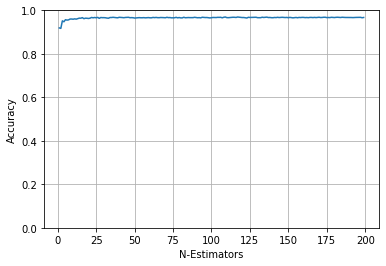

In [53]:
rf_mean_scores = rf_grid_search_cv.cv_results_["mean_test_score"]
plot_graph(rf_mean_scores, 1, len(rf_mean_scores)+1, "N-Estimators")

In [56]:
n_estimators = rf_grid_search_cv.best_params_["n_estimators"]
best_rf_clf = RandomForestClassifier(n_estimators=n_estimators)
analysis_best_estimator(df, best_rf_clf)

Precisão:  0.9582542694497154
Recall:  0.9711538461538461
ROC_AUC:  0.9714924160346696


## Gradient Tree Classifier

In [ ]:
# Construindo instância do classificador GTC e espaço de busca por iterações.
gtc_params = {"n_iter_no_change": list(range(1,200))}
gtc_clf = GradientBoostingClassifier()

# Buscando número de iterações ideal para o classificador GTC.
gtc_grid_search_cv = hyper_tuning(df, gtc_clf, gtc_params)

In [ ]:
gtc_mean_scores = gtc_grid_search_cv.cv_results_["mean_test_score"]
plot_graph(gtc_mean_scores, 1, len(gtc_mean_scores)+1, "Iterations")

In [57]:
n_iter_no_change = gtc_grid_search_cv.best_params_["n_iter_no_change"]
best_gtc_clf = GradientBoostingClassifier(n_iter_no_change=n_iter_no_change)
analysis_best_estimator(df, best_gtc_clf)

Precisão:  0.9561068702290076
Recall:  0.978515625
ROC_AUC:  0.974682400586185
